#  Smith-Wilson Model Overview

This Jupyter notebook shows you how to load the **smithwilson** model included in the **smithwilson** project. It also walks you through steps to create the same model from scratch.

The Smith-Wilson model calculates extraporated interest rates using the Smith-Wilson method.

The Smith-Wilson method is used for extraporating risk-free interest rates under the Solvency II framework. The method is described in details in *QIS 5 Risk-free interest rates – Extrapolation method*, [a technical paper](https://eiopa.europa.eu/Publications/QIS/ceiops-paper-extrapolation-risk-free-rates_en-20100802.pdf) issued by CEIOPS(the predecessor of EIOPA). The technical paper is available on [EIOPA's web site](https://eiopa.europa.eu/publications/qis/insurance/insurance-quantitative-impact-study-5/background-documents).
Formulas and variables in this notebook are named consistently with the mathmatical symbols in the technical paper.

This project is inspired by a pure Python implementation of Smith-Wilson
yield curve fitting algorithm created by Dejan Simic.
His original work can be found [on his github page](https://github.com/simicd/smith-wilson-py).

[the technical paper]: https://eiopa.europa.eu/Publications/QIS/ceiops-paper-extrapolation-risk-free-rates_en-20100802.pdf

## About this notebook

This notebook is included in **lifelib** package as part of the **smithwilson** project.

## Reading in the complete model

The complete model is included under the **smithwilson** project in lifelib package. To install lifelib package, go to Anaconda prompt and type **pip install lifelib**

In [73]:
import modelx as mx
import pandas as pd
import matplotlib.pyplot as plt
from math import log, exp
import numpy as np

In [74]:
data = pd.read_excel('//vact-svr/TIBActuarial/3 Submission/310 BNM/QT3/Data/BNM Spot Rates.xlsx')

## Building the Smith-Wilson model from scratch

We now try to create the **smithwilson** model from scratch. 
The model we create is essentially the same as the model included in the **smithwilson** project, excpt for docstrings.

Below are the steps to create the model.
1. Create a model and space.
2. Input values to as *references*.
3. Define cells.
4. Get the results.
5. Save the model.

### 1. Create a model and space

First, we create an empty model named `smithwilson2`, and also an empty space named `SmithWilson` in the model. 
The following statement creates the model and space, and assign the space to a name `s2`.

In [75]:
s2 = mx.new_model(name="smithwilson2").new_space(name="SmithWilson")

### 2. Input values to as *references*

In this step, we create *references* in the *SmithWilson* space, and assign input values to the *references*.
We will create cells and define their formulas in the sapce in the next step, and those *references* are referred by the formulas of the cells. 

The values are taken from https://github.com/simicd/smith-wilson-py/blob/master/main.py

In [76]:
s2.spot_rates = data['Risk-free (spot rate)'][0:15].values.tolist()

In [77]:
s2.spot_rates

[0.03021000000000074,
 0.030330000000000717,
 0.030380000000000663,
 0.031244075429693208,
 0.03222000000000063,
 0.03292774471805849,
 0.03343000000000059,
 0.033824979979354367,
 0.034235827566096805,
 0.03475000000000048,
 0.035399807833129994,
 0.036122895840985846,
 0.03686157735162202,
 0.03757879563579394,
 0.03825000000000037]

### Set Last Liquid Point (LLP)

In [78]:
s2.N = 15

### Set Alpha

In [79]:
# Alpha parameter in the Smith-Wilson functions
s2.alpha = 0.156  

### Set Long Term Forward Rate (LTFR)

In [80]:
ufr = 0.05    # Annual compound

In [81]:
s2.UFR = log(1 + ufr) 

You also nee to import `log` and `exp` from `math` module for later use. 
We also use numpy later, so import `numpy` as `np`. 
These functions and module need to be accessible from cells in `SmithWilson` space,
so assign them to refs.

In [82]:
s2.log = log
s2.exp = exp
s2.np = np

### 3. Define cells

In the previous step, we have assigned all the necessary inputs in the *SmithWilson* space. In this step we move on to defining cells.

We use `defcells` decorator to define cells from Python functions. `defcells` decorator creates cells in the *current* space, so confirm the *SmithWilson* space we just created is set to the *current* space by the following code.

In [83]:
mx.cur_space()

<UserSpace SmithWilson in smithwilson2>

The names of the cells below are set consistent with the mathmatical symbols in the technical paper.

* `u(i)`: Time at each `i` in years. Time steps can be uneven. For the maturities of the zero coupon bonds with known prices $u_i$
* `m(i)`: The market prices of the zero coupon bonds, $m_i$
* `mu(i)`: Ultimate Forward Rate (UFR) discount factors, $\mu_i$
* `W(i, j)`: The Wilson functions, $W(t_i, u_j)$

In [84]:
@mx.defcells
def u(i):
    """Time to maturities"""
    return i

In [85]:
@mx.defcells
def m(i):
    """Observed zero-coupon bond prices"""
    return (1 + spot_rates[i-1]) ** (-u[i])


@mx.defcells
def mu(i):
    """Ultimate Forward Rate (UFR) discount factors"""
    return exp(-UFR * u[i])

In [86]:
@mx.defcells
def W(i, j):
    """The Wilson functions"""

    t = u[i]
    uj = u[j]

    return exp(-UFR * (t+uj)) * (
            alpha * min(t, uj) - 0.5 * exp(-alpha * max(t, uj)) * (
                    exp(alpha*min(t, uj)) - exp(-alpha*min(t, uj))))

We want to use Numpy's vector and matrix operations to solve for $\zeta$,
so we create a vector or matrix version of cells for each of `m`, `mu`, `W`.
These cells have no parameter and return numpy arrays.

In [87]:
@mx.defcells
def m_vector():
    return np.array([m(i) for i in range(1, N+1)])

@mx.defcells
def mu_vector():
    return np.array([mu(i) for i in range(1, N+1)])

@mx.defcells
def W_matrix():
    return np.array(
        [[W(i, j) for j in range(1, N+1)] for i in range(1, N+1)]
    )

`zeta_vector` cells carries out the matrix-vector calcuculation: $\zeta = \bf W^{-1}(\bf m - {\mu})$.

`zeta` extracts from an element from `zeta_vector` for each `i` 

In [88]:
@mx.defcells
def zeta_vector():
    return np.linalg.inv(W_matrix()) @ (m_vector() - mu_vector())

@mx.defcells
def zeta(i):
    return zeta_vector()[i-1]

`P(i)` cells calculates bond prices from `mu`, `zeta` and `W`. The values of `P(i)` should be the same as those of `m(i)` for `i=1,...,N` .

`R(i)` are the extaporated annual compound rates. The values of `R(i)` should be the same as those of `spot_rates[i-1]` for `i=1,...,N`.

In [89]:
@mx.defcells
def P(i):
    """Zero-coupon bond prices calculated by Smith-Wilson method."""
    return mu(i) + sum(zeta(j) * W(i, j) for j in range(1, N+1))


@mx.defcells
def R(i):
    """Extrapolated rates"""
    return (1 / P(i)) ** (1 / u(i)) - 1

### 4. Get the results

You can check that the cells you define above exists in the `SmithWilson` space by getting the space's `cells` attribute.

In [90]:
s2.cells

{P,
 R,
 W,
 W_matrix,
 m,
 m_vector,
 mu,
 mu_vector,
 u,
 zeta,
 zeta_vector}

`R` cells calculates or holds the extraporated spot rates. You can see that for `i=1,...,25`, the values are the same ase the `sport_rates`.

The code below outputs `R(i)` for `i=10, 15, 20, ..., 100`

In [91]:
spot_rates = [s2.R[i] for i in range(1, 101, 1)]

In [92]:
year = [i for i in range(1, 101, 1)]

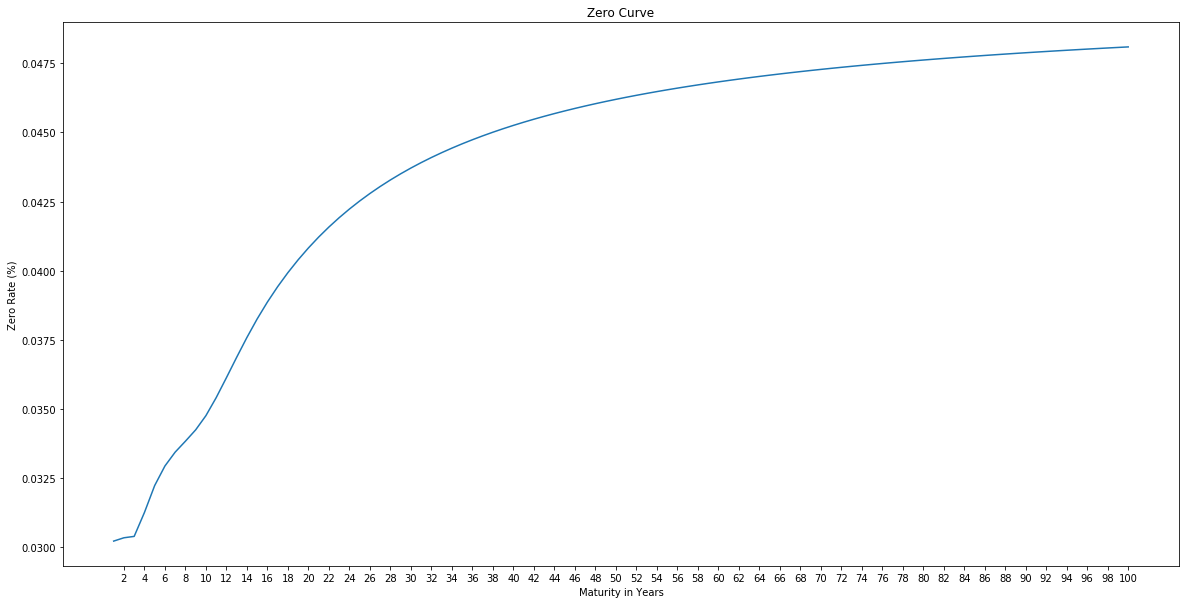

In [93]:
plt.figure(figsize=(20,10))
plt.plot(year, spot_rates)
plt.title("Zero Curve")
plt.ylabel("Zero Rate (%)")
plt.xlabel("Maturity in Years")
plt.xticks(np.arange(min(year)+1, max(year)+1, 2.0))
plt.show()

In [94]:
WS_Yield_Curve = pd.DataFrame({'Year': year, 'Spot Rates': spot_rates})
WS_Yield_Curve['Spot Rates'] = pd.Series(["{0:.3f}%".format(val * 100) for val in WS_Yield_Curve['Spot Rates']], index = WS_Yield_Curve.index)
WS_Yield_Curve

,Year,Spot Rates
0,1,3.021%
1,2,3.033%
2,3,3.038%
3,4,3.124%
4,5,3.222%
5,6,3.293%
6,7,3.343%
7,8,3.382%
8,9,3.424%
9,10,3.475%


### 5. Save the model

In [96]:
#save final data into Excel file

from datetime import date
today = date.today()
year = today.year

dirPOutput = '//vact-svr/TIBActuarial/3 Submission/310 BNM/QT3/Working/'

day = str(today.day) + "-" + str(today.month) + "-" + str(today.year)
outfile = "Smith Wilson Yield Curve @ " + day + ".xlsx"
WS_Yield_Curve.to_excel(dirPOutput + outfile)